# Global Country Development Clustering: PCA & K-Means

Bu notebook'ta, 2023 yılına ait Küresel Gelişmişlik ve Refah Endeksi verilerini inceleyeceğiz. Amacımız, ülkelerin ekonomik, sosyal ve yapısal özelliklerini kullanarak onları **"Denetimsiz Öğrenme (Unsupervised Learning)"** algoritmalarıyla gruplandırmaktır.

###  Bu Projede Neler Yapacağız?
1. **Data Preparation & Scaling:** Ülkelerin metriklerini standartlaştırma (StandardScaler).
2. **Boyut İndirgeme (PCA):** 10'dan fazla değişkeni (boyutu) insan beyninin ve algoritmaların anlayabileceği 2 boyuta sıkıştırma.
3. **K-Means Clustering (Kümeleme):** "Dirsek (Elbow)" metodunu kullanarak optimum küme sayısını bulma ve ülkeleri benzerliklerine göre haritalandırma.

In [1]:
# Temel Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn (Faz 2 Algoritmaları)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Uyarıları gizleyelim
import warnings
warnings.filterwarnings('ignore')

# Data Loading (Dosya yolunu kendi Kaggle ortamına göre teyit et)
# Genelde şöyle olur: '/kaggle/input/2023-global-country-development-and-prosperity-index/veri_dosyasi.csv'
# Aşağıdaki kodu dosyanın tam adına göre güncelle:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        print("Bulunan Dosya:", file_path)

df = pd.read_csv(file_path)

print("--- Veri Seti Boyutu ---")
print(df.shape)
display(df.head())

Bulunan Dosya: /kaggle/input/datasets/tarktunataalt/2023-global-country-development-and-prosperity-index/data.csv
--- Veri Seti Boyutu ---
(167, 14)


,Country,AveragScore,SafetySecurity,PersonelFreedom,Governance,SocialCapital,InvestmentEnvironment,EnterpriseConditions,MarketAccessInfrastructure,EconomicQuality,LivingConditions,Health,Education,NaturalEnvironment
0,Denmark,84.55,92.59,94.09,89.45,82.56,82.42,79.64,78.79,76.81,95.77,81.07,87.48,73.94
1,Sweden,83.67,90.97,91.90,86.41,78.29,82.81,75.54,79.67,76.18,95.33,82.28,85.92,78.74
2,Norway,83.59,93.30,94.10,89.66,79.03,82.24,75.95,75.87,77.25,94.70,82.98,85.68,72.37
3,Finland,83.47,89.56,91.96,90.41,77.27,84.12,77.25,78.77,70.28,94.46,81.19,88.38,77.99
4,Switzerland,83.42,95.66,87.50,87.67,69.14,80.81,83.84,78.65,79.71,94.66,82.11,87.72,73.60


#### Check-Up and Data Cleaning

In [2]:
# Column and Null Data Looking
print("--- Columns and Data Types ---")
print(df.info())

print("--- NaN Datas ---")
print(df.isnull().sum()[df.isnull().sum() > 0])

--- Columns and Data Types ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Country                     167 non-null    object 
 1   AveragScore                 167 non-null    float64
 2   SafetySecurity              167 non-null    float64
 3   PersonelFreedom             167 non-null    float64
 4   Governance                  167 non-null    float64
 5   SocialCapital               167 non-null    float64
 6   InvestmentEnvironment       167 non-null    float64
 7   EnterpriseConditions        167 non-null    float64
 8   MarketAccessInfrastructure  167 non-null    float64
 9   EconomicQuality             167 non-null    float64
 10  LivingConditions            167 non-null    float64
 11  Health                      167 non-null    float64
 12  Education                   167 non-null    float64
 13  Natu

# Socioeconomic Analysis

## Data Preparation and PCA
Ülkeleri gruplayabilmek için öncelikle verimizi makinenin anlayacağı bir standarda getirmeliyiz:
1. `Country` (Ülke) sütununu modelden ayırıp bir kenarda tutacağız.
2. `StandardScaler` ile tüm ekonomik/sosyal metrikleri aynı ölçeğe getireceğiz (Böylece büyük sayılar, küçük sayıları ezemeyecek).
3. **PCA (Principal Component Analysis):** 10'dan fazla özelliği, haritada çizebilmek için en çok bilgiyi koruyacak şekilde 2 boyuta (X ve Y ekseni) sıkıştıracağız.

PCA Data Keeping Ratio: %84.65


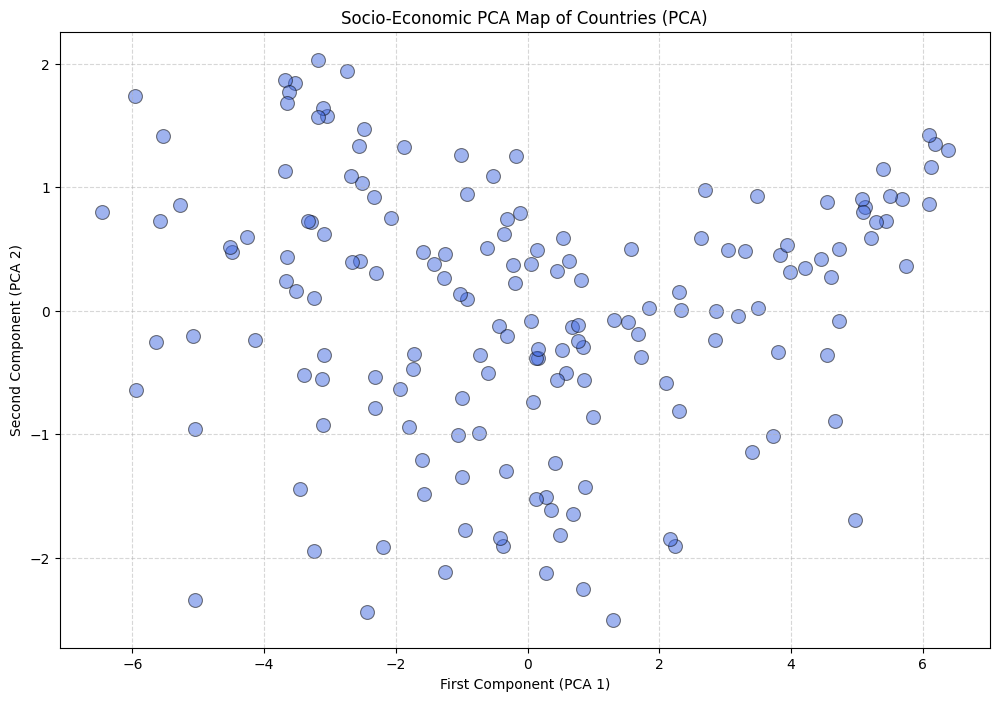

In [3]:
# Separate Country Names
countries = df['Country']
X = df.drop('Country', axis=1)

# StandardScaler - for KNN and PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Using PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# PCA Data Keeping Ratio
explained_variance = pca.explained_variance_ratio_.sum() * 100
print(f"PCA Data Keeping Ratio: %{explained_variance:.2f}")

# Country Distribution
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    s=100,
    color='royalblue',
    alpha=0.5,
    edgecolor='k'
)
plt.title("Socio-Economic PCA Map of Countries (PCA)")
plt.xlabel("First Component (PCA 1)")
plt.ylabel("Second Component (PCA 2)")

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Finding K-Means Optimum Cluster (Elbow Method)

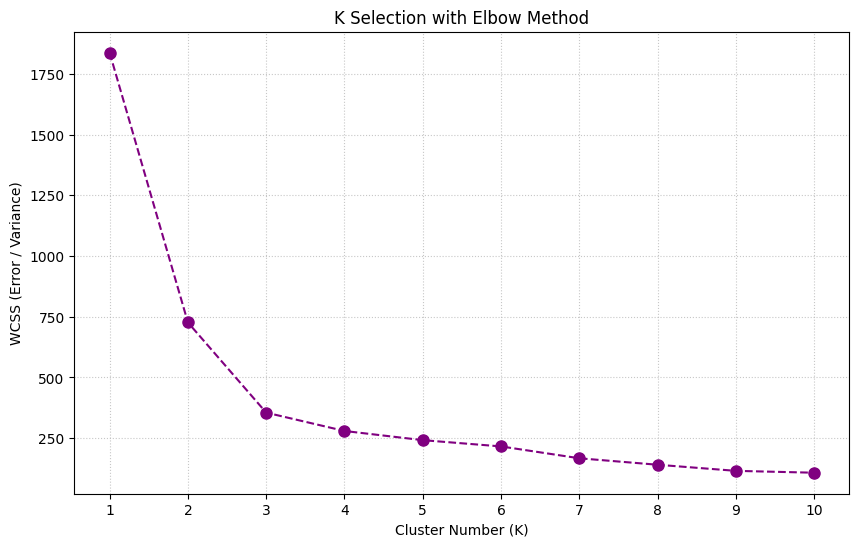

In [4]:
# Elbow Method
# WCSS (Within-Cluster Sum of Square) List
wcss = []

# Try for Different Cluster Numbers 
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca) # PCA (2 Dimension) Data
    wcss.append(kmeans.inertia_) # Tolerance (inertia)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle= '--', color = 'purple', markersize=8)
plt.title("K Selection with Elbow Method")
plt.xlabel("Cluster Number (K)")
plt.ylabel("WCSS (Error / Variance)")
plt.xticks(range(1, 11))
plt.grid(True, linestyle=':',alpha = 0.7)
plt.show()

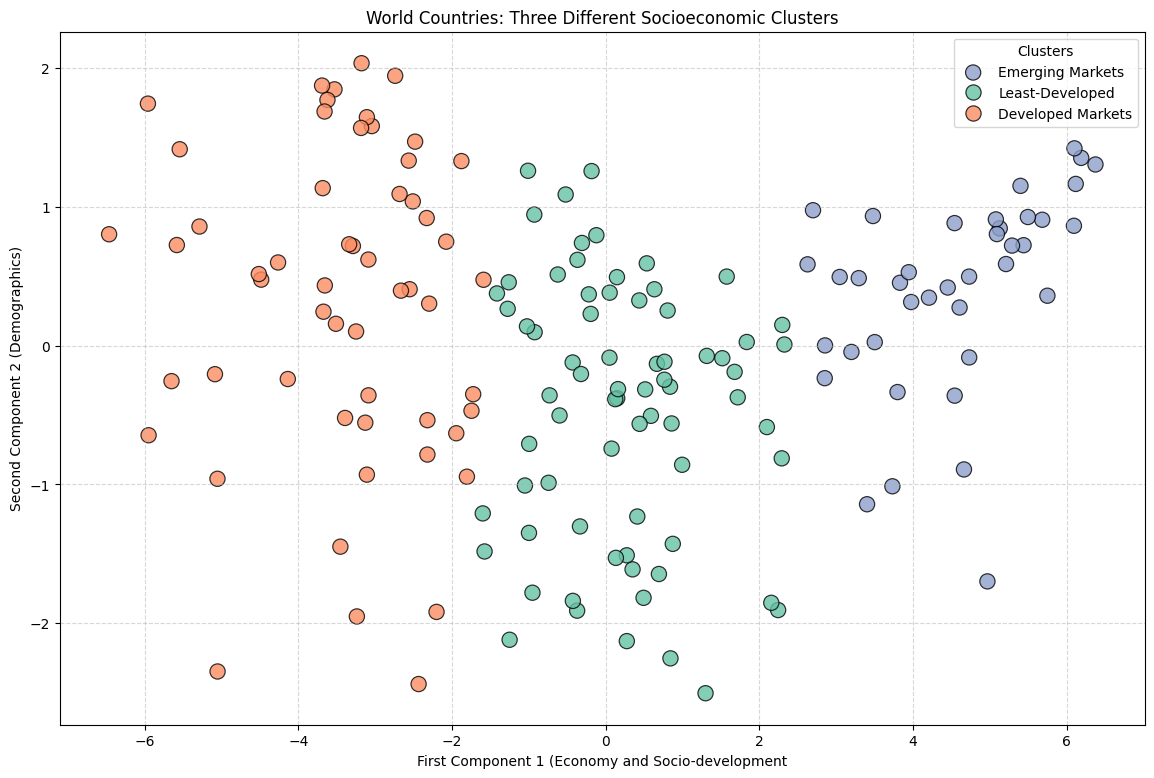

In [5]:
# Cluster of Countries (K=3)

# cluster = 3
kmeans_final = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters= kmeans_final.fit_predict(X_pca)

# Adding Clusters for PCA table and Original Dataset
df['Cluster'] = clusters
df_pca = pd.DataFrame(data=X_pca, columns = ['PCA1','PCA2'])
df_pca['Cluster'] = clusters
df_pca['Country'] = countries # Adding Countries again

# Visualization
plt.figure(figsize=(14, 9))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    data=df_pca,
    palette='Set2',
    s=120,
    alpha=0.8,
    edgecolor='k'
)

plt.title("World Countries: Three Different Socioeconomic Clusters")
plt.xlabel("First Component 1 (Economy and Socio-development")
plt.ylabel("Second Component 2 (Demographics)")
plt.legend(title='Clusters', labels= ['Emerging Markets', 'Least-Developed', 'Developed Markets'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [6]:
# Clusters Countries
print("--- First Cluster ---")
print(df[df['Cluster'] == 0]['Country'].values)
print("--- Second Cluster ---")
print(df[df['Cluster'] == 1]['Country'].values)
print("--- Third Cluster ---")
print(df[df['Cluster'] == 2]['Country'].values)

--- First Cluster ---
['\xa0Greece' '\xa0Croatia' '\xa0Hungary' '\xa0Malaysia'
 '\xa0United Arab Emirates' '\xa0Romania' '\xa0Qatar' '\xa0Mauritius'
 '\xa0Bulgaria' '\xa0Montenegro' '\xa0Panama' '\xa0Seychelles'
 '\xa0Serbia' '\xa0Georgia' '\xa0China' '\xa0Macedonia'
 '\xa0Trinidad and Tobago' '\xa0Jamaica' '\xa0Argentina' '\xa0Peru'
 '\xa0Kuwait' '\xa0Armenia' '\xa0Bahrain' '\xa0Indonesia' '\xa0Thailand'
 '\xa0Albania' '\xa0Brazil' '\xa0Oman' '\xa0Dominican Republic'
 '\xa0Kazakhstan' '\xa0Moldova' '\xa0Mexico' '\xa0Bosnia and Herzegovina'
 '\xa0Vietnam' '\xa0Ukraine' '\xa0South Africa' '\xa0Paraguay'
 '\xa0Russia' '\xa0Belarus' '\xa0Saudi Arabia' '\xa0Cabo Verde'
 '\xa0Colombia' '\xa0Suriname' '\xa0Botswana' '\xa0Philippines'
 '\xa0Ecuador' '\xa0Jordan' '\xa0São Tomé and Príncipe' '\xa0Mongolia'
 '\xa0Guyana' '\xa0Namibia' '\xa0Sri Lanka' '\xa0Azerbaijan' '\xa0Belize'
 '\xa0Kyrgyzstan' '\xa0Turkey' '\xa0Morocco' '\xa0El Salvador' '\xa0Ghana'
 '\xa0Tunisia' '\xa0Uzbekistan' '\xa0Guate

## Socio-Economic Insight

Bu projede, 167 ülkeye ait karmaşık makro-ekonomik ve sosyal metrikleri (10+ boyut) **PCA (Principal Component Analysis)** kullanarak verinin %84.65'ini koruyacak şekilde 2 boyuta indirgedik. Ardından **K-Means Clustering** algoritması ile ülkeleri etiket kullanmadan, sadece matematiksel benzerliklerine göre gruplandırdık. 

**Dirsek Metodu (Elbow Method)** bize en ideal küme sayısının 3 olduğunu gösterdi. Makinenin oluşturduğu bu 3 küme, dünyanın gerçek jeopolitik yapısıyla kusursuz bir uyum içindedir:

### Cluster Analysis:
*  **Cluster 0 (Gelişmekte Olan ve Dalgalı Ekonomiler):** Türkiye, Arjantin, Brezilya ile birlikte Balkanlar ve Doğu Avrupa bloğunun çoğunlukta olduğu gruptur. Bu ülkeler belirli bir sanayi ve gelişim seviyesine ulaşmış olsalar da, genellikle ekonomik krizler, enflasyon veya yapısal dalgalanmalarla karakterize edilirler.
*  **Cluster 1 (Az Gelişmiş / Kırılgan Ülkeler):** Afganistan, Suriye, Sudan, Yemen gibi ülkelerin bulunduğu bu grup; savaş, siyasi istikrarsızlık veya aşırı yoksulluk nedeniyle ekonomik ve sosyal gelişimini tamamlayamamış, refah seviyesi en düşük olan coğrafyaları temsil eder.
*  **Cluster 2 (Gelişmiş Refah Ülkeleri):** İskandinav ülkeleri (Danimarka, İsveç), ABD, Japonya ve Batı Avrupa bloğu. İnsani Gelişmişlik Endeksinin, eğitim seviyesinin ve kişi başına düşen milli gelirin en yüksek olduğu, stabil ve yüksek refahlı "Birinci Dünya" ülkeleridir.

### İş ve Veri Bilimi Çıkarımı:
Denetimsiz Öğrenme (Unsupervised Learning) algoritmaları, elimizde hiçbir hedef (target) etiket olmasa bile verideki gizli desenleri bulmada olağanüstü bir başarı göstermiştir. Bu tarz segmentasyon modelleri; uluslararası şirketlerin pazar giriş stratejileri belirlemesinde, IMF gibi kurumların kredi sınıflandırmalarında veya küresel risk analizlerinde doğrudan kullanılabilecek niteliktedir.

# Creating AI-HDI
##  Özellik Mühendisliği (Feature Engineering) ile AI-HDI Yaratmak

K-Means ve PCA algoritmalarının dünyayı ne kadar iyi anladığını gördük. Şimdi bir adım daha ileri gidiyoruz: **"Madem PCA 1 (Ana Bileşen 1) ekseni ülkenin gelişmişliğini en iyi açıklayan eksen, neden bunu 0-100 arası bir skora çevirmiyoruz?"**

Bu adımda:
1. PCA 1 değerlerini `MinMaxScaler` ile 0-100 arasına sıkıştırıp kendi **Yapay Zeka İnsani Gelişmişlik Endeksimizi (AI-HDI)** yaratacağız.
2. Bu skorun 3 farklı kümedeki dağılımını görselleştireceğiz.
3. Dünyanın en gelişmiş ve en az gelişmiş ülkelerini sıralayacağız.

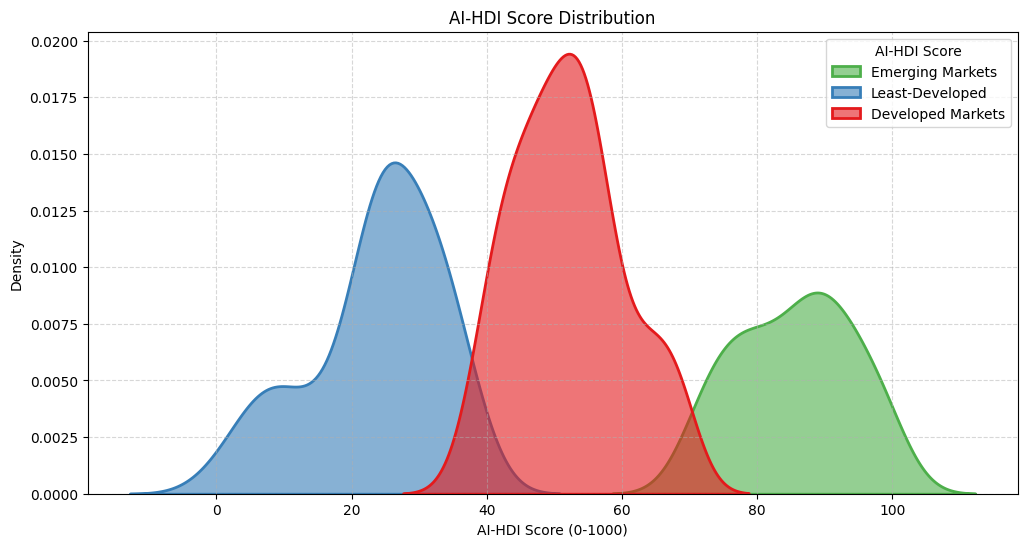

In [7]:
from sklearn.preprocessing import MinMaxScaler

# AI-HDI Score Calculation
pca_1_values = df_pca['PCA1'].values.reshape(-1, 1)

# Scaling Around 0 and 1000
scaler_hdi = MinMaxScaler(feature_range=(0, 100))
df_pca['AI_HDI_Score'] = scaler_hdi.fit_transform(pca_1_values)

# PCA Trend can be '-' and '+'
# Developed Countries score should be higher so we will fix trend
dev_mean = df_pca[df_pca['Cluster'] == 2]['AI_HDI_Score'].mean()
if dev_mean < 50:
    df_pca['AI_HDI_Score'] = 100 - df_pca['AI_HDI_Score']

# Visualization (KDEplot)
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=df_pca,
    x='AI_HDI_Score',
    hue='Cluster',
    fill=True,
    palette='Set1',
    alpha=0.6,
    linewidth=2
)
plt.title("AI-HDI Score Distribution")
plt.xlabel('AI-HDI Score (0-1000)')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title = "AI-HDI Score",labels=['Emerging Markets', 'Least-Developed', 'Developed Markets'])
plt.show()

In [8]:
# Ranking Countries
ranking_df = df_pca[['Country', 'AI_HDI_Score','Cluster']].sort_values(by='AI_HDI_Score', ascending=False)
ranking_df['AI_HDI_Score'] = ranking_df['AI_HDI_Score'].round(2)

print("First 10 Countries AI-HDI-Index")
display(ranking_df.head(10))

print("Last 10 Countries AI-HDI-Index")
display(ranking_df.tail(10))

First 10 Countries AI-HDI-Index


,Country,AI_HDI_Score,Cluster
0,Denmark,100.00,2
1,Sweden,98.55,2
2,Norway,98.00,2
3,Finland,97.87,2
4,Switzerland,97.82,2
5,Netherlands,95.13,2
6,Luxembourg,94.60,2
7,Iceland,93.15,2
8,Germany,92.71,2
9,New Zealand,92.40,2


Last 10 Countries AI-HDI-Index


,Country,AI_HDI_Score,Cluster
158,Syria,11.00,1
157,Sudan,10.99,1
159,Eritrea,10.73,1
160,Democratic Republic of Congo,9.16,1
161,Chad,7.16,1
162,Somalia,6.87,1
163,Afghanistan,6.33,1
165,Yemen,4.00,1
164,Central African Republic,3.94,1
166,South Sudan,0.00,1


##  AI-HDI Insight

PCA algoritmamızın ürettiği **Ana Bileşen 1 (PCA 1)** eksenini kullanarak kendi 0-100 ölçekli **Yapay Zeka İnsani Gelişme Endeksimizi (AI-HDI)** yarattık. Ortaya çıkan tablo ve dağılım grafikleri, makine öğrenmesinin hiçbir etiket olmadan gerçek dünyayı ne kadar kusursuz simüle edebildiğini kanıtlıyor!

### Nordic Victory (Kuzey Avrupa ve Refah Ülkeleri)
* Modelimiz, **100 tam puanla Danimarka'yı** dünyanın en gelişmiş ülkesi seçti. Onu İsveç, Norveç, Finlandiya ve İsviçre takip ediyor. 
* *Gerçek Dünya Uyumu:* Birleşmiş Milletler'in (BM) yayınladığı gerçek İnsani Gelişme Endeksi (HDI) raporlarına bakıldığında zirve tam olarak bu ülkelerden oluşmaktadır. Algoritma, BM uzmanlarının aylarca süren ekonomik analizlerini sadece matematiksel varyanslara bakarak saniyeler içinde doğrulamıştır!

### Last 10 Countries (Kriz ve Çatışma Bölgeleri)
* Listenin en dibinde **0.00 puanla Güney Sudan**, hemen üstünde ise Orta Afrika Cumhuriyeti, Yemen, Afganistan ve Suriye yer alıyor. 
* *Gerçek Dünya Uyumu:* Model; savaş, iç çatışma ve yapısal çöküşlerin makro-ekonomiye vurduğu yıkıcı darbeyi matematiksel olarak tespit edip, küresel refahtan pay alamayan bu ülkeleri tablonun en altına yerleştirmiştir.

### AI-HDI Distribution (KDE Plot) Analysis
Yoğunluk grafiğini incelediğimizde dünya ekonomisinin matematiksel bir özetini görüyoruz:
1. **Büyük Yığılma:** Ülkelerin çok büyük bir kısmı (Gelişmekte Olan ve Kırılgan Ekonomiler) alt ve orta seviyelerde yoğunlaşmış durumdadır. Grafiğin sol tarafındaki devasa tepe bu gerçeği yansıtır.
2. **İzole Zirve:** En sağdaki gelişmiş ülkeler bölgesi, daha az sayıda ülkeden oluşan, ulaşılması zor ve izole bir "Refah Adasını" temsil etmektedir.

### İş Zekası ve Veri Bilimi Çıkarımı:
Bu proje, **Özellik Mühendisliğinin (Feature Engineering)** sınırlarını zorladığımız bir çalışma olmuştur. PCA'in (Temel Bileşenler Analizi) sadece boyutları küçülten basit bir araç olmadığını; aynı zamanda eğitim, sağlık, ekonomi gibi onlarca farklı metriği en optimize şekilde birleştirerek tek bir **"Süper Metrik" (Index)** haline getirebilen muazzam bir analitik güç olduğunu kanıtladık.